In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from copy import copy, deepcopy
import random
import math
import pickle

In [2]:
"""create action arrays"""
def define_action_space(i):
  actions=[]
  if(i==1):
    a1=np.array([[0],[0],[0],[0]])
    a2=np.array([[0],[1],[0],[0]])
    a3=np.array([[0],[0],[1],[0]])
    a4=np.array([[0],[0],[1],[1]])
    a5=np.array([[0],[0],[0],[1]])
    actions.append(a1)
    actions.append(a2)
    actions.append(a3)
    actions.append(a4)
    actions.append(a5)
  else:
    a1=np.array([[0],[0],[0],[0]])
    a2=np.array([[0],[1],[0],[0]])
    a3=np.array([[0],[0],[1],[0]])
    a4=np.array([[0],[0],[0],[1]])
    actions.append(a1)
    actions.append(a2)
    actions.append(a3)
    actions.append(a4)
  return actions

In [3]:
"""test create action"""
def test_define_action_space():
  action_op1=define_action_space(1)
  actions_op0=define_action_space(0)
  assert(len(action_op1)==5)
  temp_array=np.array([[0],[0],[0],[1]])
  assert(np.array_equal(action_op1[4],temp_array))
  assert(np.array_equal(actions_op0[3],temp_array))
  assert(len(actions_op0)==4)
test_define_action_space()

In [4]:
def create_states():
  states=[]
  first_array=np.array([[0],[0],[0],[0]])
  for i in range(16):
    number_list=[]
    byte_string='{0:04b}'.format(i)
    for ch in byte_string:
      number_list.append(int(ch))
    states.append(np.asarray(number_list).reshape(4,1))
  return states
#create_states()

In [5]:
np.shape(create_states())

(16, 4, 1)

In [6]:
def state_to_Index(input_state):
  dim=np.shape(input_state)[0]
  index=0
  for i in range(dim):
    index+=math.pow(2,i)*input_state[i]
  return int(index)

In [7]:
def test_state_to_Index():
  test_input_state=np.array([[1],[1],[0],[1]])
  assert(state_to_Index(test_input_state)==11)
  test_input_state=np.array([[1],[1],[1],[1]])
  assert(state_to_Index(test_input_state)==15)
test_state_to_Index()

In [8]:
def computeL1Norm(a):   # assumes input is np array of shape x,1
  norm=0
  for i in range(np.shape(a)[0]):
    norm+=np.abs(a[i][0])
  return norm

In [9]:
def test_computeL1Norm():
  arr=np.array([[0],[1],[2]])
  assert(computeL1Norm(arr)==3)
test_computeL1Norm()

In [10]:
def calculate_two_state_reward(state1,state2,action):  # state 2 is the destination state
  return computeL1Norm(5*state2)-computeL1Norm(action)

In [11]:
def test_calculate_two_state_reward():
  state1=np.array([[1],[0]])
  state2=np.array([[0],[1]])
  action=np.array([[1],[1]])
  test_ans=calculate_two_state_reward(state1, state2,action)
  assert(test_ans==3)
test_calculate_two_state_reward()

In [12]:
def create_some_noise(vector_size,p):
  return np.random.binomial(1,p,vector_size).reshape(vector_size,1)

In [13]:
def test_create_some_noise():
  print(create_some_noise(4,0.05))
test_create_some_noise()

[[0]
 [0]
 [0]
 [0]]


In [14]:
# assume matrix is np array of shape(x,1)
def vectorize_matrix(some_matrix):
  dim1 = np.shape(some_matrix)[0]
  for i in range(dim1):
    if(some_matrix[i,0]>0):
      some_matrix[i,0]=1
    else:
      some_matrix[i,0]=0
  return some_matrix

In [15]:
def test_vectorize_matrix():
  test_matrix=np.array([[2],[0],[0],[0]])
  test_matrix=vectorize_matrix(test_matrix)
  assert(test_matrix[0,0]==1)
  assert(test_matrix[2,0]==0)
test_vectorize_matrix()

In [16]:
def computeXOR(a,b):
  xor=[]
  for i in range(np.shape(a)[0]):
    if(a[i][0]==b[i][0]):
      ans=0
    else:
      ans=1
    xor.append(ans)
  return np.asarray(xor).reshape(np.shape(a)[0],1)

In [17]:
def test_compute_XOR():
  arr1=np.array([[0],[0],[1],[1]])
  arr2=np.array([[0],[1],[0],[1]])
  arr3=computeXOR(arr1,arr2)
  assert(arr3.shape==(4,1))
  assert(arr3[0][0]==0)
  assert(arr3[1][0]==1)
  assert(arr3[2][0]==1)
  assert(arr3[3][0]==0)
test_compute_XOR()

In [18]:
def compute_next_state(connectivity_matrix,current_state,action,noise):
  assert(np.shape(current_state)[0]==4)
  assert(np.shape(current_state)[1]==1)
  assert(np.shape(action)[0]==4)
  assert(np.shape(action)[1]==1)
  next_state=computeXOR(computeXOR(vectorize_matrix(np.matmul(connectivity_matrix,current_state)),action),noise)
  return next_state

In [19]:
def test_compute_next_state():
  connectivity_matrix=np.array([[0,0,-1,0],[1,0,-1,-1],[0,1,0,0],[-1,1,1,0]])
  test_action=np.array([[0],[0],[0],[1]])
  test_state=np.array([[0],[1],[1],[1]])
  noise=np.array([[0],[0],[0],[0]])
  test_next_state=np.array([[0],[0],[1],[0]])
  assert(np.array_equal(test_next_state,np.array([[0],[0],[1],[0]])))
test_compute_next_state()

**Q-Learning**

In [20]:
def create_Q_Matrix(action_space_size):
  Q_Matrix=np.zeros(shape=(16,action_space_size))
  for i in range(16):
    for k in range(action_space_size):
      Q_Matrix[i,k]=0
  return Q_Matrix

In [21]:
def test_create_Q_Matrix():
  test_state=create_states()
  test_Q_Matrix=create_Q_Matrix(4)
  assert(np.shape(test_Q_Matrix)[1]==4)
  assert(np.shape(test_Q_Matrix)[0]==16)
  #assert(np.shape(test_Q_Matrix)[1]==4)
  assert(test_Q_Matrix[0,0]==0)
test_create_Q_Matrix()

In [22]:
def epsilonGreedy(qlist,epsilon):
  #qlist=[qa1,qa2,qa3,qa4]
  action = np.random.uniform()
  action_space_size=len(qlist)
  # exploration
  if(action<epsilon):
    #print("in exploration")
    non_greedy_choice=random.randint(0,action_space_size-1)
    #print("greedy choice:{}".format(greedy_choice))
    action_taken=non_greedy_choice+1
    '''if(non_greedy_choice==0):
      action_taken=1
    elif(non_greedy_choice==1):
      action_taken=2
    elif(non_greedy_choice==2):
      action_taken=3
    elif(non_greedy_choice==3):
      action_taken=4'''
    return action_taken
  # greedy approach - exploitation
  # randommization for equal case
  maxq=max(qlist)
  if(qlist[0]==qlist[1]):
    maxindex=random.randint(0,1)
  max_list=[]
  for i in range(len(qlist)):
    if(np.isclose(qlist[i],maxq)):
      max_list.append(i)
  maxindex = random.choice(max_list)
  #print(maxindex)
  action_taken=maxindex+1
  return action_taken

In [33]:
def test_epsilon_greedy():
  print(epsilonGreedy([1,2,3,4],0.9))
test_epsilon_greedy()

1


In [34]:
def find_max_Q(qmatrix,i,action_space_size):
  max=qmatrix[i,0]
  pos=0
  for k in range(action_space_size):
    if(qmatrix[i,k]>max):
      max=qmatrix[i,k]
      pos=k
  # check for multiple equal Q-values
  maxposlist=[]
  for k in range(action_space_size):
    if(qmatrix[i,k]==max):
      maxposlist.append(k)
  #print(maxposlist)
  pos=np.random.choice(maxposlist)
  max=qmatrix[i,pos]
  return max,pos

In [35]:
def test_find_max_Q():
  qmatrix=create_Q_Matrix(4)
  start_state=np.array([[0],[0],[0],[0]])
  max_item,max_index=find_max_Q(qmatrix,0,4)
  assert(max_item==0)
  print(max_index)
test_find_max_Q()

2


In [36]:
def Q_Learning(value_matrix,action_space_size,epsilon,alpha,gamma,p,episodes_limit,steps_limit,start_state,connectivity_matrix):
  # states must be a 4x1 np array
  Q_Matrix=create_Q_Matrix(action_space_size)
  rewards_in_episodes=[]
  vector_actions=define_action_space(3)
  for i in range(episodes_limit):
    # an episode
    in_episode_total=0
    state=start_state
    steps_iter=0
    while(steps_iter<steps_limit):
      steps_iter+=1
      current_state_index=state_to_Index(state)
      qlist=[]
      for j in range(action_space_size):
        qlist.append(Q_Matrix[current_state_index,j])
      action_to_take=epsilonGreedy(qlist,epsilon)
      potential_next_state=compute_next_state(connectivity_matrix,state,vector_actions[action_to_take-1],create_some_noise(4,p))
      reward=calculate_two_state_reward(state,potential_next_state,vector_actions[action_to_take-1])
      in_episode_total+=reward
      max_q,max_q_action=find_max_Q(Q_Matrix,state_to_Index(potential_next_state),action_space_size)
      Q_Matrix[current_state_index,action_to_take-1]+=alpha*(reward+gamma*max_q-Q_Matrix[current_state_index,action_to_take-1])
      state=potential_next_state
    rewards_in_episodes.append(in_episode_total/steps_iter)
  return Q_Matrix,rewards_in_episodes

In [37]:
def average_rewards_across_runs(no_of_runs,rewards_across_runs):
  averaged_rewards=[]
  for k in range(len(rewards_across_runs)):
    rewards_across_runs[k]=np.cumsum(rewards_across_runs[k])
    for l1 in range(len(rewards_across_runs[k])):
      rewards_across_runs[k][l1]=(rewards_across_runs[k][l1])/(l1+1)
  for i in range(len(rewards_across_runs[0])):
    component_total=0
    for j in range(len(rewards_across_runs)):
      component_total+=rewards_across_runs[j][i]
    averaged_rewards.append(component_total/(len(rewards_across_runs)))
  return averaged_rewards

In [38]:
def test_average_rewards_across_runs():
  test_input=[]
  for i in range(10):
    test_ip=[0]*500
    test_input.append(test_ip)
  test_out=average_rewards_across_runs(10,test_input)
  assert(len(test_out)==500)
test_average_rewards_across_runs()

In [39]:
def get_connectivity_matrix():
  connectivity_matrix=np.array([[0,0,-1,0],[1,0,-1,-1],[0,1,0,0],[-1,1,1,0]])
  return connectivity_matrix

In [40]:
def test_get_connectivity_matrix():
  print(get_connectivity_matrix())
test_get_connectivity_matrix()

[[ 0  0 -1  0]
 [ 1  0 -1 -1]
 [ 0  1  0  0]
 [-1  1  1  0]]


In [41]:
def generate_Q_learning_policy(Q_Matrix):
  xdim=Q_Matrix.shape[0]
  action_space_size=Q_Matrix.shape[1]
  policy=np.zeros((xdim))
  for i in range(xdim):
    max_q,max_q_action=find_max_Q(Q_Matrix,i,action_space_size)
    policy[i]=int(max_q_action)
  return policy

In [76]:
def plot_episode_wise_rewards(rewards_in_episodes):
  xdim=len(rewards_in_episodes)
  fig, bob = plt.subplots(figsize=(10, 10),dpi=80)
  bob.set(title = "Accumulated reward vs episodes for alpha=0.2",xlabel = "episodes", ylabel = "Accumulated reward")
  bob.plot(range(xdim),rewards_in_episodes)
  #plt.legend(['epsilon=0','epsilon=0.1','epsilon=0.2','epsilon=0.5'])
  plt.show()

In [43]:
def printPolicy(policy):
  policy_to_print=[]
  for i in range(np.shape(policy)[0]):
    if(policy[i]==0):
      policy_to_print.append('a0')
    elif(policy[i]==1):
      policy_to_print.append('a1')
    elif(policy[i]==2):
      policy_to_print.append('a2')
    elif(policy[i]==3):
      policy_to_print.append('a3')
  return policy_to_print

Policy for 1 iteration
['a1', 'a2', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 2 iteration
['a1', 'a1', 'a1', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 3 iteration
['a1', 'a1', 'a1', 'a3', 'a1', 'a0', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 4 iteration
['a1', 'a0', 'a1', 'a2', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 5 iteration
['a1', 'a3', 'a1', 'a2', 'a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 6 iteration
['a1', 'a3', 'a1', 'a0', 'a1', 'a0', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 7 iteration
['a1', 'a0', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 8 iteration
['a1', 'a0', 'a1', 'a0', 'a1', 'a3', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 9 iteration
['a1', 'a3', 'a1'

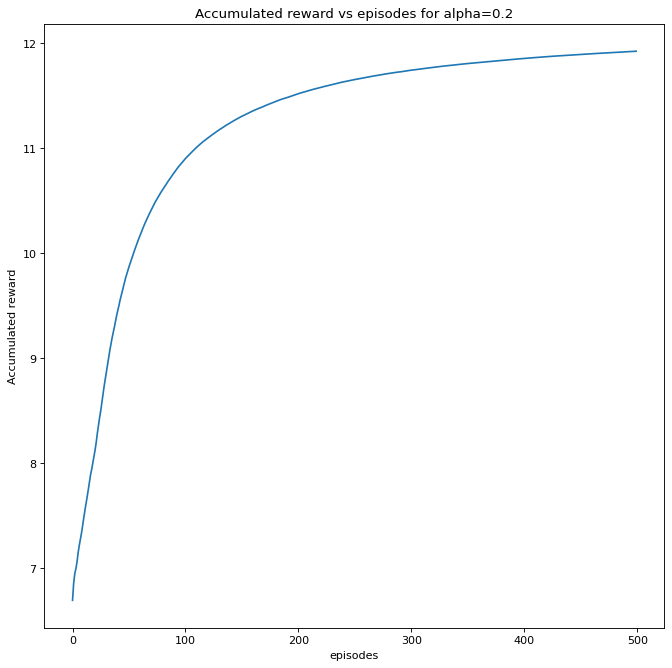

In [81]:
def run_Q_Learning(no_of_runs):
  start_state=np.array([[0],[0],[0],[0]])
  value_matrix=np.zeros(shape=(16,1))
  rewards_across_runs=[]
  start_state=np.array([[0],[0],[0],[0]])
  for i in range(no_of_runs):
    connectivity_matrix=get_connectivity_matrix()
    q,rewards=Q_Learning(value_matrix,4,0.1,0.2,0.95,0.05,500,500,start_state=np.array([[0],[0],[0],[0]]),connectivity_matrix=get_connectivity_matrix())
    policy=generate_Q_learning_policy(q)
    rewards_across_runs.append(rewards)
    print("Policy for {} iteration".format(i+1))
    print_policy=printPolicy(policy)
    print(print_policy)
    #if(policy[state_to_Index(start_state)]==3):
    #  policy_to_display=policy
    #path=create_path_dict(policy)
    #path_to_goal_exsists(path)
  rewards=average_rewards_across_runs(no_of_runs,rewards_across_runs)
  plot_episode_wise_rewards(rewards)
  #draw_graphs(policy_to_display,rewards)
  return rewards
q_learning_rewards=run_Q_Learning(10)

**SARSA**

In [44]:
def SARSA_learning(value_matrix,action_space_size,epsilon,alpha,gamma,p,episodes_limit,steps_limit,start_state,connectivity_matrix):
  sarsa_matrix=create_Q_Matrix(action_space_size)
  vector_actions=define_action_space(3)
  rewards_in_episodes=[]
  for i in range(episodes_limit):
    state=start_state
    current_state_index=state_to_Index(state)
    sarsa_list=[]
    for j in range(action_space_size):
      sarsa_list.append(sarsa_matrix[current_state_index,j])
    action_to_take=epsilonGreedy(sarsa_list,epsilon)
    in_episode_total=0
    steps_iter=0
    while(steps_iter<steps_limit):
      steps_iter+=1
      if(steps_iter>steps_limit):
        break
      potential_next_state=compute_next_state(connectivity_matrix,state,vector_actions[action_to_take-1],create_some_noise(4,p))
      next_state_index=state_to_Index(potential_next_state)
      reward=calculate_two_state_reward(state,potential_next_state,vector_actions[action_to_take-1])
      in_episode_total+=reward
      sarsa_next_list=[]
      for k1 in range(action_space_size):
        sarsa_next_list.append(sarsa_matrix[next_state_index,k1])
      action_in_next_state=epsilonGreedy(sarsa_next_list,epsilon)
      sarsa_matrix[current_state_index,action_to_take-1]+=alpha*(reward+gamma*sarsa_matrix[next_state_index,action_in_next_state-1]-sarsa_matrix[current_state_index,action_to_take-1])
      state=potential_next_state
      action_to_take=action_in_next_state
      current_state_index=next_state_index
    rewards_in_episodes.append(in_episode_total/steps_iter)
  return sarsa_matrix,rewards_in_episodes

Policy for 1 iteration
['a2', 'a2', 'a1', 'a3', 'a1', 'a3', 'a1', 'a0', 'a1', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1']
Policy for 2 iteration
['a2', 'a2', 'a1', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 3 iteration
['a1', 'a2', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 4 iteration
['a1', 'a1', 'a1', 'a3', 'a1', 'a2', 'a1', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 5 iteration
['a1', 'a0', 'a1', 'a1', 'a1', 'a2', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 6 iteration
['a1', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 7 iteration
['a1', 'a1', 'a1', 'a0', 'a1', 'a3', 'a1', 'a0', 'a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 8 iteration
['a1', 'a2', 'a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 9 iteration
['a2', 'a2', 'a1'

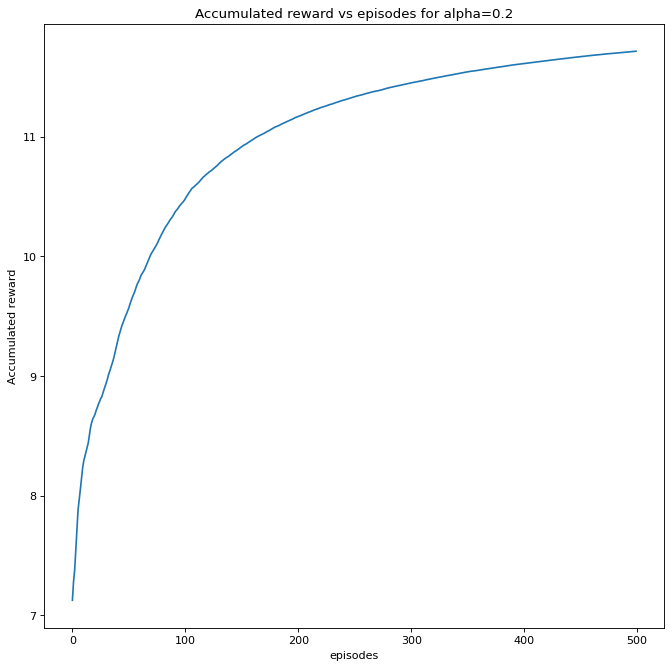

In [ ]:
def run_SARSA_Learning(no_of_runs):
  start_state=np.array([[0],[0],[0],[0]])
  value_matrix=np.zeros(shape=(16,1))
  rewards_across_runs=[]
  start_state=np.array([[0],[0],[0],[0]])
  for i in range(no_of_runs):
    connectivity_matrix=get_connectivity_matrix()
    sarsa,rewards=SARSA_learning(value_matrix,4,0.1,0.2,0.95,0.05,500,500,start_state=np.array([[0],[0],[0],[0]]),connectivity_matrix=get_connectivity_matrix())
    policy=generate_Q_learning_policy(sarsa)
    rewards_across_runs.append(rewards)
    print("Policy for {} iteration".format(i+1))
    print_policy=printPolicy(policy)
    print(print_policy)
  rewards=average_rewards_across_runs(no_of_runs,rewards_across_runs)
  plot_episode_wise_rewards(rewards)
  return rewards
sarsa_rewards=run_SARSA_Learning(10)

**SARSA-LAMBDA**

In [45]:
def sarsa_lamda_update(sarsa_matrix,error_matrix,delta,alpha,gamma):
  state_space_size=np.shape(sarsa_matrix)[0]
  action_space_size=np.shape(sarsa_matrix)[1]
  for i in range(state_space_size):
    for j in range(action_space_size):
      sarsa_matrix[i,j]+=alpha*delta*error_matrix[i,j]
      error_matrix[i,j]=error_matrix[i,j]*gamma
  return sarsa_matrix,error_matrix

In [46]:
def SARSA_lambda(value_matrix,action_space_size,epsilon,alpha,gamma,p,episodes_limit,steps_limit,start_state,connectivity_matrix):
  sarsa_matrix=create_Q_Matrix(action_space_size)
  vector_actions=define_action_space(3)
  rewards_in_episodes=[]
  for i in range(episodes_limit):
    state=start_state
    current_state_index=state_to_Index(state)
    sarsa_list=[]
    error_matrix=create_Q_Matrix(action_space_size)
    for j in range(action_space_size):
      sarsa_list.append(sarsa_matrix[current_state_index,j])
    action_to_take=epsilonGreedy(sarsa_list,epsilon)
    in_episode_total=0
    steps_iter=0
    while(steps_iter<steps_limit):
      steps_iter+=1
      if(steps_iter>steps_limit):
        break
      potential_next_state=compute_next_state(connectivity_matrix,state,vector_actions[action_to_take-1],create_some_noise(4,p))
      next_state_index=state_to_Index(potential_next_state)
      reward=calculate_two_state_reward(state,potential_next_state,vector_actions[action_to_take-1])
      in_episode_total+=reward
      sarsa_next_list=[]
      for k1 in range(action_space_size):
        sarsa_next_list.append(sarsa_matrix[next_state_index,k1])
      action_in_next_state=epsilonGreedy(sarsa_next_list,epsilon)
      delta=alpha*(reward+gamma*sarsa_matrix[next_state_index,action_in_next_state-1]-sarsa_matrix[current_state_index,action_to_take-1])
      error_matrix[current_state_index,action_to_take-1]+=1
      sarsa_matrix,error_matrix=sarsa_lamda_update(sarsa_matrix,error_matrix,delta)
      #next state updates
      state=potential_next_state
      action_to_take=action_in_next_state
      current_state_index=next_state_index
    rewards_in_episodes.append(in_episode_total/steps_iter)
  return sarsa_matrix,rewards_in_episodes

Policy for 1 iteration
['a1', 'a3', 'a1', 'a0', 'a1', 'a3', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 2 iteration
['a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 3 iteration
['a1', 'a0', 'a1', 'a1', 'a1', 'a3', 'a1', 'a0', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1']
Policy for 4 iteration
['a2', 'a2', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 5 iteration
['a1', 'a0', 'a1', 'a3', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 6 iteration
['a1', 'a2', 'a1', 'a0', 'a2', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 7 iteration
['a2', 'a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 8 iteration
['a1', 'a0', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a2', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1']
Policy for 9 iteration
['a1', 'a3', 'a1'

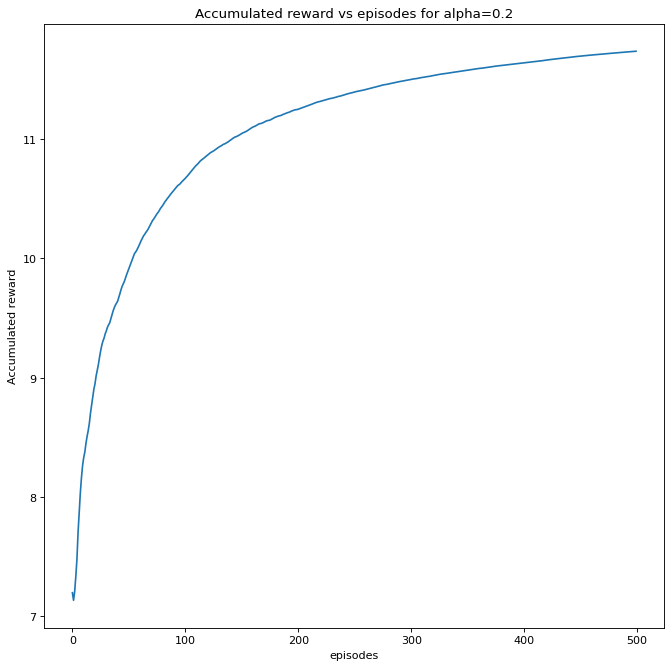

In [ ]:
def run_SARSA_Lambda_Learning(no_of_runs):
  start_state=np.array([[0],[0],[0],[0]])
  value_matrix=np.zeros(shape=(16,1))
  rewards_across_runs=[]
  start_state=np.array([[0],[0],[0],[0]])
  for i in range(no_of_runs):
    connectivity_matrix=get_connectivity_matrix()
    sarsa,rewards=SARSA_learning(value_matrix,4,0.1,0.2,0.95,0.05,500,500,start_state=np.array([[0],[0],[0],[0]]),connectivity_matrix=get_connectivity_matrix())
    policy=generate_Q_learning_policy(sarsa)
    rewards_across_runs.append(rewards)
    print("Policy for {} iteration".format(i+1))
    print_policy=printPolicy(policy)
    print(print_policy)
  rewards=average_rewards_across_runs(no_of_runs,rewards_across_runs)
  plot_episode_wise_rewards(rewards)
  return rewards # change this
sarsa_lambda_rewards=run_SARSA_Lambda_Learning(10)

**Actor-Critic**

In [47]:
def actor_critic_action(action_space_size,policy,x):
  # returns 0,1,2,3
  poslist=[]
  #print(policy[0,0,0])
  for i in range(action_space_size):
    poslist.append(i)
  return np.random.choice(poslist,p=policy[x])

In [48]:
def test_actor_critic_action():
  test_policy=np.array([[0.25,0.25,0.25,0.25]])
  #print(np.shape(test_policy))
  #print(actor_critic_action(4,test_policy,0,0))
  #assert(actor_critic_action(4,test_policy,0,0)==2 or actor_critic_action(4,test_policy,0,0)==3)
  test_policy2=np.zeros(shape=[2,4])
  print(np.shape(test_policy2))
  test_policy2[0]=[0.5,0.1,0.2,0.2]
  test_policy2[1]=[0.5,0.2,0.3,0.0]
  print(actor_critic_action(4,test_policy,0))
test_actor_critic_action()

(2, 4)
0


In [49]:
def recompute_policy(preference_matrix,policy_matrix,x,action_space_size):
  expo_sum=0
  for i in range(action_space_size):
    expo_sum+=np.exp(preference_matrix[x,i])
  for j in range(action_space_size):
    policy_matrix[x,j]=np.exp(preference_matrix[x,j])/expo_sum
  return policy_matrix

In [50]:
def test_recompute_policy():
  test_policy=np.array([[0,0.1,0.2,0.2]])
  test_preference=np.array([[0,0,0,0]])
  ans=recompute_policy(test_preference,test_policy,0,4)
  assert(ans[0,0]==0.25)
  assert(ans[0,1]==0.25)
  assert(ans[0,2]==0.25)
  assert(ans[0,3]==0.25)
  # sum of all policy matrix at state should be 1
test_recompute_policy()

In [68]:
def get_random_state():
  states_set=create_states()
  xdim=np.shape(states_set)[0]
  random_number = random.randint(0,xdim-1)
  return states_set[random_number]

In [70]:
def test_get_random_state():
  print(get_random_state())
test_get_random_state()

[[1]
 [0]
 [1]
 [0]]


In [75]:
def actor_critic(value_matrix,gamma,alpha,beta,action_space_size,episodes_limit,steps_limit,p,start_state,connectivity_matrix):
  qMatrix=create_Q_Matrix(action_space_size)
  xdim=np.shape(qMatrix)[0]
  vMatrix=np.zeros([xdim,1])
  preference_matrix=np.zeros(shape=(xdim,action_space_size))
  policy_matrix=np.zeros(shape=(xdim,action_space_size))
  vector_actions=define_action_space(3)
  #put np.nan in these matrices for wall states
  for i in range(xdim):
    for a in range(action_space_size):
      policy_matrix[i,a]=(1/action_space_size)
  rewards=[]
  for i in range(episodes_limit):
    #state=start_state
    state=get_random_state()
    cx=state_to_Index(start_state)
    step_count=0
    episode_Reward=0
    while(step_count<steps_limit):
      step_count+=1
      action_to_take=actor_critic_action(action_space_size,policy_matrix,cx)
      potential_next_state=compute_next_state(connectivity_matrix,state,vector_actions[action_to_take],create_some_noise(4,p))
      next_state_index=state_to_Index(potential_next_state)
      reward=calculate_two_state_reward(state,potential_next_state,vector_actions[action_to_take])
      delta=reward+gamma*vMatrix[next_state_index] - vMatrix[cx]
      vMatrix[cx] = vMatrix[cx]+alpha*delta
      preference_matrix[cx,action_to_take]+=beta*delta*(1-policy_matrix[cx,action_to_take])
      #recompute policy for cx,cy
      policy_matrix=recompute_policy(preference_matrix,policy_matrix,cx,action_space_size)
      cx=next_state_index
      episode_Reward+=reward
    rewards.append(episode_Reward/step_count)
  return policy_matrix,rewards

In [65]:
def generate_actor_critic_policy(policy_matrix):
  xdim=np.shape(policy_matrix)[0]
  action_space_size=np.shape(policy_matrix)[1]
  policy=np.zeros(shape=(xdim))
  for i in range(xdim):
    maxpos=0
    for k in range(action_space_size):
      if(policy_matrix[i,k]>policy_matrix[i,maxpos]):
        maxpos=k
    policy[i]=int(maxpos)
  return policy

In [66]:
def test_generate_actor_critic_policy():
  test_policy_matrix1=test_policy=np.array([[0.0,0.2,0.7,0.1]])
  print(np.shape(test_policy_matrix1))
  test_policy=generate_actor_critic_policy(test_policy_matrix1)
  print(test_policy[0])
test_generate_actor_critic_policy()

(1, 4)
2.0


Policy for 1 iteration
['a3', 'a1', 'a3', 'a3', 'a3', 'a2', 'a3', 'a0', 'a1', 'a3', 'a1', 'a3', 'a1', 'a3', 'a3', 'a0']
Policy for 2 iteration
['a2', 'a1', 'a2', 'a1', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a1', 'a0', 'a2', 'a2', 'a2', 'a2']
Policy for 3 iteration
['a1', 'a2', 'a2', 'a1', 'a3', 'a1', 'a3', 'a2', 'a3', 'a3', 'a3', 'a1', 'a3', 'a2', 'a1', 'a3']
Policy for 4 iteration
['a3', 'a1', 'a1', 'a1', 'a3', 'a2', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a3', 'a2', 'a1', 'a3']
Policy for 5 iteration
['a3', 'a1', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a3', 'a0', 'a1', 'a0']
Policy for 6 iteration
['a1', 'a3', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a1', 'a3', 'a3', 'a2', 'a2', 'a3', 'a1']
Policy for 7 iteration
['a2', 'a2', 'a1', 'a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a0', 'a1', 'a1', 'a1', 'a2', 'a1', 'a3']
Policy for 8 iteration
['a1', 'a1', 'a3', 'a3', 'a3', 'a1', 'a3', 'a2', 'a3', 'a3', 'a3', 'a2', 'a1', 'a3', 'a3', 'a3']
Policy for 9 iteration
['a1', 'a1', 'a2'

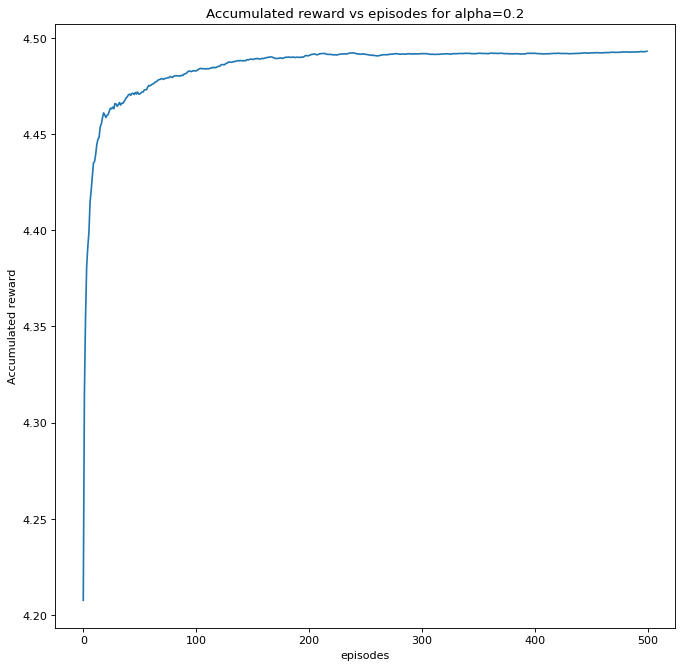

In [74]:
def run_actor_critic(no_of_runs):
  rewards_across_runs=[]
  start_state=np.array([[0],[0],[0],[0]])
  for i in range(no_of_runs):
    value_matrix=create_Q_Matrix(4)
    policy_matrix,rewards=actor_critic(value_matrix,0.95,0.2,0.05,4,500,500,0.05,start_state,get_connectivity_matrix())
    policy=generate_actor_critic_policy(policy_matrix)
    print("Policy for {} iteration".format(i+1))
    print_policy=printPolicy(policy)
    print(print_policy)
    rewards_across_runs.append(rewards)
  rewards=average_rewards_across_runs(no_of_runs,rewards_across_runs)
  plot_episode_wise_rewards(rewards)
  return rewards
actor_critic_learning_rewards=run_actor_critic(10)

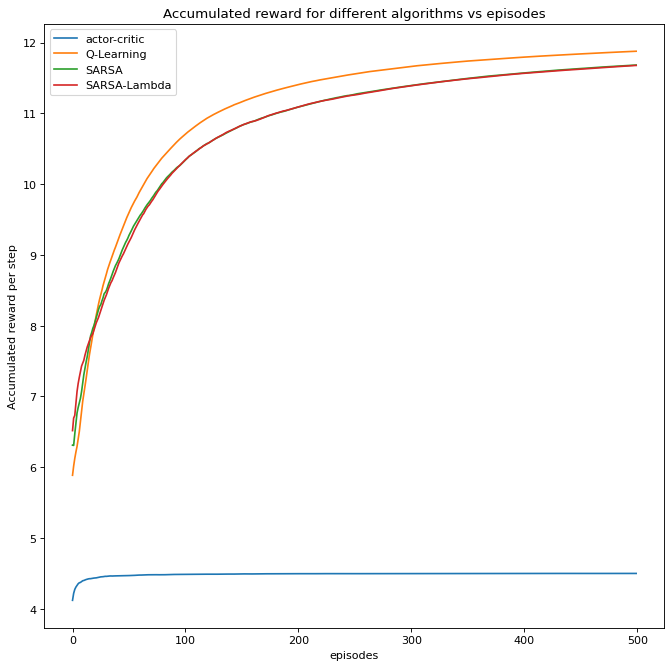

In [ ]:
fig, bob = plt.subplots(figsize=(10, 10),dpi=80)
bob.set(title = "Accumulated reward for different algorithms vs episodes",xlabel = "episodes", ylabel = "Accumulated reward per step")
bob.plot(range(500),actor_critic_learning_rewards)
bob.plot(range(500),q_learning_rewards)
bob.plot(range(500),sarsa_rewards)
bob.plot(range(500),sarsa_lambda_rewards)
plt.legend(['actor-critic','Q-Learning','SARSA','SARSA-Lambda'])
plt.show()

Policy for 1 iteration
['a2', 'a3', 'a3', 'a2', 'a1', 'a1', 'a3', 'a3', 'a1', 'a1', 'a2', 'a2', 'a1', 'a0', 'a0', 'a0']
Policy for 2 iteration
['a2', 'a3', 'a3', 'a1', 'a0', 'a0', 'a3', 'a0', 'a1', 'a2', 'a2', 'a2', 'a1', 'a1', 'a1', 'a3']
Policy for 3 iteration
['a2', 'a0', 'a3', 'a0', 'a1', 'a3', 'a3', 'a0', 'a0', 'a1', 'a2', 'a2', 'a0', 'a0', 'a2', 'a0']
Policy for 4 iteration
['a3', 'a2', 'a2', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a2', 'a1', 'a2', 'a1', 'a0', 'a1', 'a1']
Policy for 5 iteration
['a3', 'a1', 'a2', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a2', 'a1', 'a0', 'a1', 'a1']
Policy for 6 iteration
['a2', 'a1', 'a3', 'a2', 'a0', 'a1', 'a3', 'a0', 'a1', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1']
Policy for 7 iteration
['a1', 'a2', 'a2', 'a1', 'a3', 'a1', 'a1', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 8 iteration
['a3', 'a0', 'a2', 'a1', 'a3', 'a1', 'a2', 'a2', 'a1', 'a0', 'a1', 'a2', 'a1', 'a2', 'a1', 'a1']
Policy for 9 iteration
['a2', 'a3', 'a3'

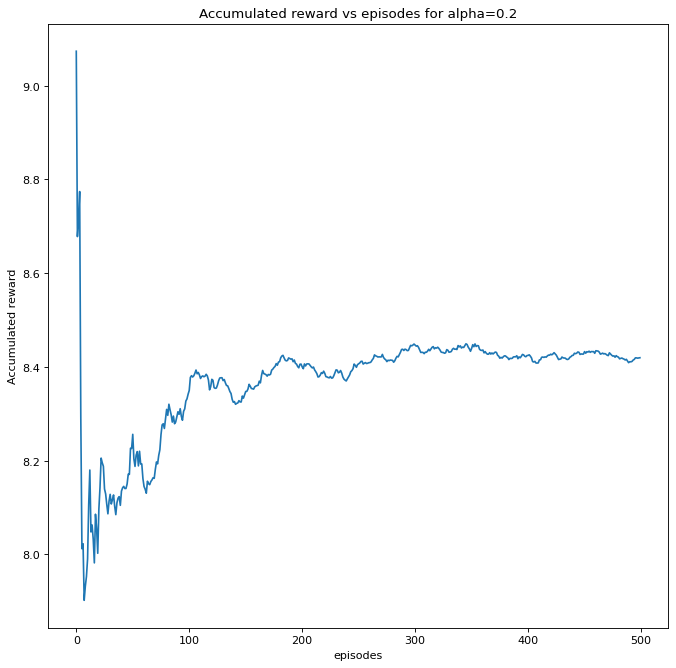

In [79]:
def run_actor_critic_again(no_of_runs):
  rewards_across_runs=[]
  start_state=np.array([[0],[0],[0],[0]])
  for i in range(no_of_runs):
    value_matrix=create_Q_Matrix(4)
    policy_matrix,rewards=actor_critic(value_matrix,0.95,0.2,0.05,4,500,500,0.05,start_state,get_connectivity_matrix())
    policy=generate_actor_critic_policy(policy_matrix)
    print("Policy for {} iteration".format(i+1))
    print_policy=printPolicy(policy)
    print(print_policy)
    rewards_across_runs.append(rewards)
  rewards=average_rewards_across_runs(no_of_runs,rewards_across_runs)
  plot_episode_wise_rewards(rewards)
  return rewards

actor_critic_learning_rewards2=run_actor_critic_again(10)

Policy for 1 iteration
['a2', 'a3', 'a3', 'a1', 'a2', 'a1', 'a3', 'a0', 'a1', 'a1', 'a2', 'a0', 'a1', 'a1', 'a1', 'a1']
Policy for 2 iteration
['a2', 'a3', 'a3', 'a2', 'a2', 'a1', 'a2', 'a2', 'a1', 'a0', 'a1', 'a1', 'a1', 'a0', 'a0', 'a0']
Policy for 3 iteration
['a3', 'a1', 'a2', 'a0', 'a1', 'a1', 'a3', 'a3', 'a1', 'a1', 'a0', 'a2', 'a1', 'a1', 'a1', 'a1']
Policy for 4 iteration
['a3', 'a2', 'a2', 'a1', 'a1', 'a1', 'a3', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a0', 'a1']
Policy for 5 iteration
['a2', 'a2', 'a3', 'a2', 'a1', 'a3', 'a3', 'a3', 'a0', 'a1', 'a2', 'a3', 'a1', 'a0', 'a0', 'a0']
Policy for 6 iteration
['a2', 'a3', 'a3', 'a2', 'a1', 'a3', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 7 iteration
['a2', 'a0', 'a3', 'a2', 'a1', 'a0', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 8 iteration
['a2', 'a1', 'a3', 'a2', 'a3', 'a3', 'a2', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 9 iteration
['a2', 'a3', 'a2'

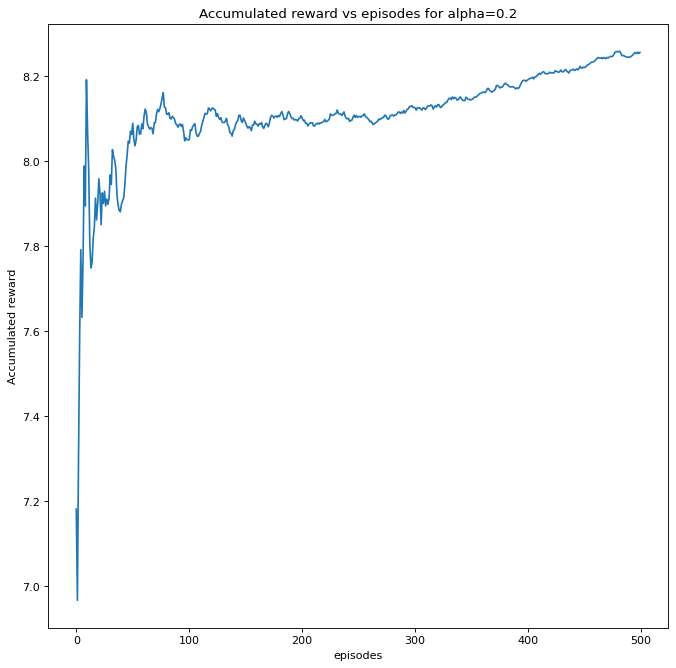

Policy for 1 iteration
['a2', 'a3', 'a2', 'a3', 'a1', 'a0', 'a3', 'a2', 'a0', 'a2', 'a1', 'a2', 'a1', 'a0', 'a1', 'a3']
Policy for 2 iteration
['a1', 'a3', 'a3', 'a2', 'a1', 'a3', 'a3', 'a3', 'a3', 'a2', 'a2', 'a2', 'a1', 'a1', 'a1', 'a3']
Policy for 3 iteration
['a2', 'a2', 'a3', 'a3', 'a2', 'a3', 'a2', 'a2', 'a1', 'a1', 'a1', 'a0', 'a1', 'a0', 'a1', 'a1']
Policy for 4 iteration
['a1', 'a3', 'a2', 'a3', 'a3', 'a1', 'a1', 'a0', 'a1', 'a3', 'a1', 'a1', 'a1', 'a2', 'a1', 'a1']
Policy for 5 iteration
['a2', 'a3', 'a2', 'a2', 'a3', 'a0', 'a0', 'a3', 'a1', 'a2', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1']
Policy for 6 iteration
['a2', 'a3', 'a1', 'a2', 'a3', 'a0', 'a3', 'a3', 'a1', 'a2', 'a1', 'a0', 'a0', 'a0', 'a0', 'a1']
Policy for 7 iteration
['a2', 'a2', 'a3', 'a2', 'a1', 'a3', 'a0', 'a0', 'a1', 'a2', 'a3', 'a0', 'a1', 'a3', 'a1', 'a1']
Policy for 8 iteration
['a2', 'a0', 'a2', 'a2', 'a3', 'a3', 'a1', 'a1', 'a1', 'a2', 'a1', 'a2', 'a1', 'a1', 'a1', 'a0']
Policy for 9 iteration
['a1', 'a2', 'a3'

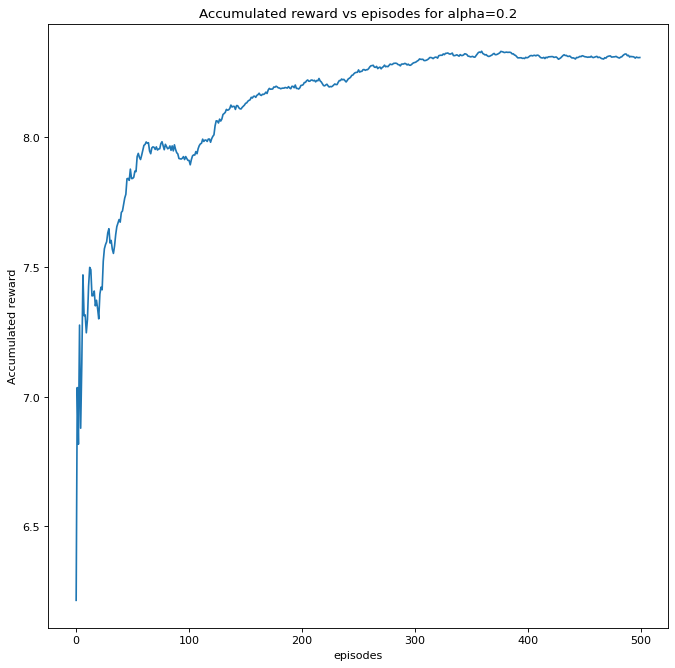

Policy for 1 iteration
['a2', 'a1', 'a3', 'a2', 'a1', 'a3', 'a3', 'a0', 'a2', 'a0', 'a3', 'a3', 'a0', 'a0', 'a0', 'a1']
Policy for 2 iteration
['a2', 'a0', 'a3', 'a0', 'a1', 'a1', 'a1', 'a1', 'a2', 'a0', 'a0', 'a1', 'a1', 'a0', 'a1', 'a0']
Policy for 3 iteration
['a2', 'a1', 'a3', 'a1', 'a3', 'a0', 'a1', 'a1', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1']
Policy for 4 iteration
['a2', 'a2', 'a3', 'a3', 'a1', 'a3', 'a3', 'a3', 'a2', 'a1', 'a3', 'a3', 'a1', 'a0', 'a0', 'a1']
Policy for 5 iteration
['a2', 'a3', 'a3', 'a1', 'a3', 'a1', 'a1', 'a1', 'a1', 'a2', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1']
Policy for 6 iteration
['a2', 'a1', 'a3', 'a3', 'a0', 'a3', 'a3', 'a0', 'a1', 'a1', 'a3', 'a3', 'a0', 'a0', 'a3', 'a3']
Policy for 7 iteration
['a3', 'a3', 'a2', 'a2', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a0', 'a1', 'a1']
Policy for 8 iteration
['a2', 'a0', 'a3', 'a2', 'a3', 'a1', 'a1', 'a1', 'a1', 'a1', 'a1', 'a0', 'a1', 'a0', 'a1', 'a1']
Policy for 9 iteration
['a2', 'a3', 'a2'

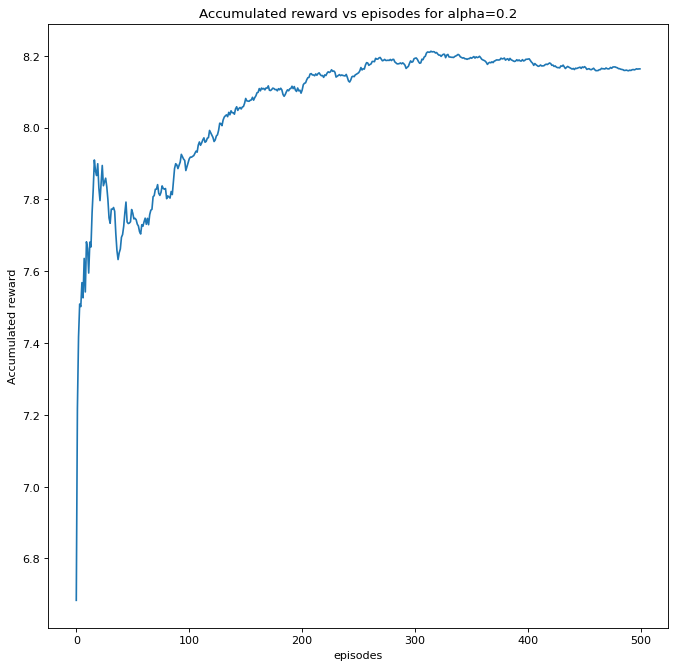

Policy for 1 iteration
['a3', 'a2', 'a2', 'a3', 'a0', 'a3', 'a3', 'a1', 'a1', 'a0', 'a1', 'a2', 'a1', 'a1', 'a1', 'a1']


KeyboardInterrupt: ignored

In [80]:
alpha_values=[0.01,0.05,0.1]
beta_values=[0.001,0.005,0.01]
varying_actor_critic_rewards=[]
for a in alpha_values:
  for b in beta_values:
    varying_actor_critic_rewards.append(run_actor_critic_again(10))
fig, bob = plt.subplots(figsize=(10, 10),dpi=80)
bob.set(title = "Accumulated reward vs episodes for alpha=0.2",xlabel = "episodes", ylabel = "Accumulated reward")
for i in range(len(varying_actor_critic_rewards)):
  bob.plot(range(500),varying_actor_critic_rewards[i])
plt.legend(['alpha=0.01 & beta=0.001','alpha=0.01 & beta=0.005','alpha=0.01 & beta=0.01','alpha=0.05 & beta=0.001','alpha=0.05 & beta=0.005','alpha=0.05 & beta=0.01','alpha=0.1 & beta=0.001','alpha=0.1 & beta=0.005','alpha=0.1 & beta=0.01'])
plt.show()